In [70]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from collections import Counter


KMER = 6
DIR_EXP = Path(f"../experiments-paper/{KMER}mer")
NAME_EXPERIMENT = "07_25_2024-autoencoder"

path_experiment = DIR_EXP.joinpath("07_25_2024-autoencoder")


labels issues and outliers are saved in the order of the test sets used for kfold cross-validation
___

In [71]:
kfold_test = list(
    path_experiment.joinpath("cross-validation").glob("test*")
)
kfold_test.sort()
kfold_test

paths_fcgr = []
labels = []

for kfold in kfold_test:

    with open(kfold) as fp:
        for line in fp.readlines():
            path_fcgr, label = line.strip().split("\t")

            if path_fcgr not in df_outliers.path:
                labels.append(label)
                paths_fcgr.append(path_fcgr)

df_labels = pd.DataFrame({
    "path_fcgr": paths_fcgr,
    "label": labels
})
df_labels["sample_id"] = df_labels.path_fcgr.apply(lambda s: Path(s).stem)

df_labels.head()

,path_fcgr,label,sample_id
0,data/fcgr/6mer/salmonella_enterica__20/SAMN060...,salmonella_enterica,SAMN06034028
1,data/fcgr/6mer/escherichia_coli__21/SAMN097384...,escherichia_coli,SAMN09738459
2,data/fcgr/6mer/salmonella_enterica__46/SAMN103...,salmonella_enterica,SAMN10391382
3,data/fcgr/6mer/neisseria_meningitidis__02/SAME...,neisseria_meningitidis,SAMEA2147963
4,data/fcgr/6mer/salmonella_enterica__18/SAMN053...,salmonella_enterica,SAMN05357778


In [72]:
unique_labels = list(df_labels.label.unique())
unique_labels.sort()
dict_int2label = {idx: label for idx, label in enumerate(unique_labels)}

### Outliers
___

In [73]:
# outliers
df_outliers = pd.read_csv( path_experiment.joinpath("cross-validation/outliers/outliers.csv"), sep="\t") 

In [74]:
df_outliers.head()

,Unnamed: 0,path,label,avg_dist
0,22385,data/fcgr/6mer/dustbin__10/SAMN02744650.npy,candidatus_desulforudis_audaxviator,0.573974
1,105591,data/fcgr/6mer/dustbin__21/SAMN02801811.npy,candidatus_sulcia_muelleri,0.573294
2,43758,data/fcgr/6mer/dustbin__10/SAMN06320183.npy,candidatus_desulforudis_audaxviator,0.384791
3,41954,data/fcgr/6mer/dustbin__21/SAMN02923777.npy,mobiluncus_curtisii,0.377866
4,28016,data/fcgr/6mer/dustbin__08/SAMN02745225.npy,rhodovulum_sp._p5,0.364298


In [75]:
df_outliers.groupby("label").size().sort_values(ascending=False)

label
escherichia_coli              244
staphylococcus_aureus         177
salmonella_enterica           145
streptococcus_pneumoniae       91
mycobacterium_tuberculosis     88
                             ... 
vibrio_tritonius                1
vitreoscilla_sp._c1             1
weeksella_virosa                1
weissella_jogaejeotgali         1
weissella_koreensis             1
Length: 1585, dtype: int64

### Label issues
___

In [76]:
# label issues
path_cf = path_experiment.joinpath("cross-validation/confident-learning")
label_issues = np.load( path_cf.joinpath("label_issues.npy") ) 
labels = np.load( path_cf.joinpath("labels.npy") ) 
labels.shape

(657775,)

In [77]:
pred_probs = np.load( path_cf.joinpath("pred_probs.npy") )

In [78]:
preds = [dict_int2label[int(x)] for x in pred_probs.argmax(axis=1) ]
len(preds)

657775

In [79]:
label_issues

array([False, False, False, ..., False, False, False])

In [80]:
df_labels["pred"] = preds
df_labels_issues = df_labels.loc[label_issues]
df_labels_issues

,path_fcgr,label,sample_id,pred
25,data/fcgr/6mer/staphylococcus_aureus__10/SAMN0...,staphylococcus_aureus,SAMN02391400,enterococcus_faecium
41,data/fcgr/6mer/dustbin__04/SAMN05734408.npy,providencia_sp._wchpr000369,SAMN05734408,providencia_alcalifaciens
46,data/fcgr/6mer/dustbin__16/SAMEA1462955.npy,bacteroides_ovatus,SAMEA1462955,megasphaera_hexanoica
108,data/fcgr/6mer/dustbin__19/SAMN04477626.npy,enterococcus_cecorum,SAMN04477626,staphylococcus_epidermidis
112,data/fcgr/6mer/dustbin__17/SAMN04487944.npy,xanthomonas_euvesicatoria,SAMN04487944,lactobacillus_gasseri
...,...,...,...,...
657082,data/fcgr/6mer/dustbin__18/SAMN05216290.npy,pseudopedobacter_saltans,SAMN05216290,haliscomenobacter_hydrossis
657106,data/fcgr/6mer/dustbin__19/SAMN00998671.npy,corynebacterium_glutamicum,SAMN00998671,corynebacterium_striatum
657183,data/fcgr/6mer/mycolicibacterium_smegmatis__01...,mycolicibacterium_smegmatis,SAMN08961557,mycolicibacterium_gilvum
657209,data/fcgr/6mer/dustbin__01/SAMN05444320.npy,amycolatopsis_albispora,SAMN05444320,geodermatophilus_obscurus


In [93]:
# total
num_label_by_specie = Counter(df_labels.label)

# with label issues
counts = Counter(df_labels_issues.label)
counts_label_issues = pd.DataFrame({"species": counts.keys(), "count": counts.values()})

# add total for species
counts_label_issues["total"] = counts_label_issues["species"].apply(lambda s: num_label_by_specie[s])
counts_label_issues["p_issues"] = counts_label_issues.apply(lambda row: row["count"]/row["total"],axis=1)


<Axes: xlabel='count', ylabel='species'>

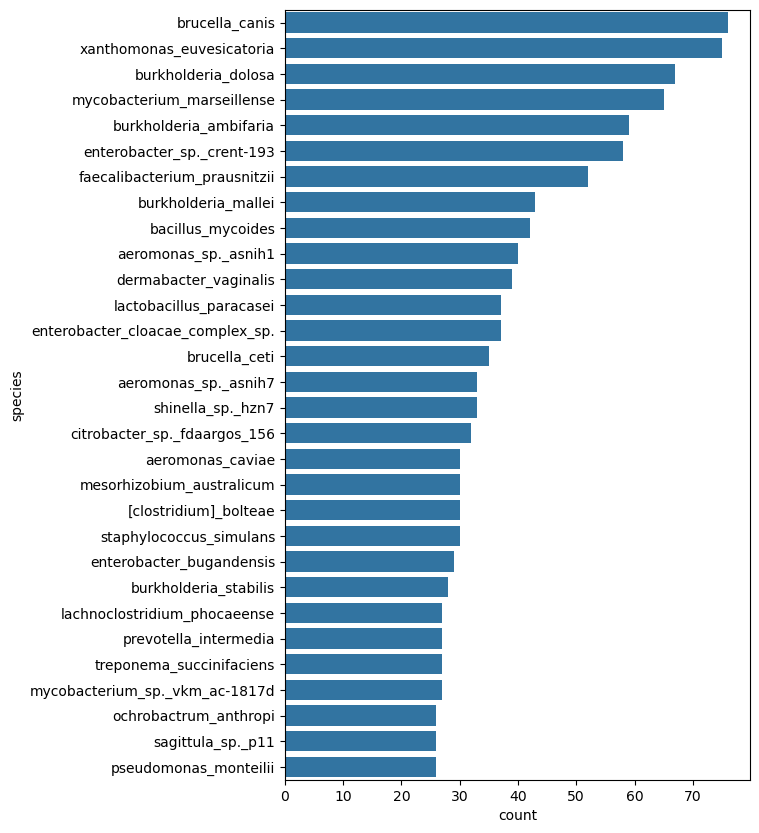

In [95]:
fix, ax = plt.subplots(figsize=(6,10))


feat = "count"
counts_label_issues.sort_values(by=feat, ascending=False, inplace=True)
counts_label_issues.reset_index(inplace=True, drop=True)

sns.barplot(
    data=counts_label_issues.query("total < 100").head(30),
    y="species", x=feat,
    orient="h",
    ax=ax
)

In [96]:
counts_label_issues.query("total < 100").head(20) 

,species,count,total,p_issues
19,brucella_canis,76,77,0.987013
20,xanthomonas_euvesicatoria,75,82,0.914634
23,burkholderia_dolosa,67,71,0.943662
24,mycobacterium_marseillense,65,70,0.928571
26,burkholderia_ambifaria,59,67,0.880597
27,enterobacter_sp._crent-193,58,59,0.983051
31,faecalibacterium_prausnitzii,52,84,0.619048
36,burkholderia_mallei,43,44,0.977273
37,bacillus_mycoides,42,59,0.711864
39,aeromonas_sp._asnih1,40,66,0.606061


In [97]:
df_label_by_species = pd.DataFrame({
    "species": num_label_by_specie.keys(),
    "count": num_label_by_specie.values(),
})

In [98]:
df_label_by_species.query("count>=100")["count"].sum()

np.int64(635852)

In [99]:
df_label_by_species.query("count<100")["count"].sum()

np.int64(21923)

Compare against most abundant species
___

In [100]:
df_most_abundant = pd.read_csv("../data/three_most_abundant-krakenbracken.txt",sep="\t")
df_most_abundant.rename({
    "V2": "species1",
    "V3": "abundancy1",
    "V4": "species2",
    "V5": "abundancy2",
    "V6": "species3",
    "V7": "abundancy3",
}, inplace=True, axis=1)

In [101]:
df_most_abundant.head()

,sample_id,species1,abundancy1,species2,abundancy2,species3,abundancy3
0,SAMD00000344,Lactobacillus hokkaidonensis,99.093,Lactobacillus plantarum,0.159,Lactobacillus amylophilus,0.110
1,SAMD00000345,Xanthomonas euvesicatoria,27.153,Lactobacillus plantarum,18.485,Lactobacillus brevis,3.043
2,SAMD00000355,Streptococcus pyogenes,97.942,Streptococcus agalactiae,0.883,Streptococcus dysgalactiae,0.858
3,SAMD00000550,Corynebacterium glutamicum,93.780,[Brevibacterium] flavum,2.292,Corynebacterium crudilactis,1.066
4,SAMD00000552,Corynebacterium glutamicum,99.951,Kluyveromyces marxianus,0.015,Acetobacter pasteurianus,0.012


In [102]:
pd.merge(left=df_labels_issues, right=df_most_abundant ,how="left", on="sample_id")

,path_fcgr,label,sample_id,pred,species1,abundancy1,species2,abundancy2,species3,abundancy3
0,data/fcgr/6mer/staphylococcus_aureus__10/SAMN0...,staphylococcus_aureus,SAMN02391400,enterococcus_faecium,Staphylococcus aureus,77.434,Enterococcus casseliflavus,6.579,Enterococcus faecium,6.499
1,data/fcgr/6mer/dustbin__04/SAMN05734408.npy,providencia_sp._wchpr000369,SAMN05734408,providencia_alcalifaciens,Providencia sp. WCHPr000369,45.632,Providencia rettgeri,44.142,Providencia stuartii,3.037
2,data/fcgr/6mer/dustbin__16/SAMEA1462955.npy,bacteroides_ovatus,SAMEA1462955,megasphaera_hexanoica,Bacteroides ovatus,19.185,Bacteroides thetaiotaomicron,5.579,Bacteroides caecimuris,4.906
3,data/fcgr/6mer/dustbin__19/SAMN04477626.npy,enterococcus_cecorum,SAMN04477626,staphylococcus_epidermidis,Enterococcus cecorum,2.564,Enterococcus faecium,2.338,Jeotgalibaca sp. PTS2502,2.259
4,data/fcgr/6mer/dustbin__17/SAMN04487944.npy,xanthomonas_euvesicatoria,SAMN04487944,lactobacillus_gasseri,Xanthomonas euvesicatoria,4.763,Parageobacillus thermoglucosidasius,4.194,Paraliobacillus sp. X-1125,3.391
...,...,...,...,...,...,...,...,...,...,...
12246,data/fcgr/6mer/dustbin__18/SAMN05216290.npy,pseudopedobacter_saltans,SAMN05216290,haliscomenobacter_hydrossis,Pseudopedobacter saltans,3.601,Salegentibacter sp. T436,1.696,Zunongwangia profunda,1.489
12247,data/fcgr/6mer/dustbin__19/SAMN00998671.npy,corynebacterium_glutamicum,SAMN00998671,corynebacterium_striatum,Corynebacterium glutamicum,9.586,Corynebacterium striatum,9.517,Corynebacterium simulans,7.511
12248,data/fcgr/6mer/mycolicibacterium_smegmatis__01...,mycolicibacterium_smegmatis,SAMN08961557,mycolicibacterium_gilvum,Mycolicibacterium smegmatis,37.168,Mycobacterium tuberculosis,23.256,Mycobacterium sp. MCS,11.252
12249,data/fcgr/6mer/dustbin__01/SAMN05444320.npy,amycolatopsis_albispora,SAMN05444320,geodermatophilus_obscurus,Amycolatopsis albispora,3.970,Streptomyces lividans,3.376,Allokutzneria albata,3.216
